In [1]:
# install.packages("FactoMineR", repos="https://cloud.r-project.org/")
library(FactoMineR)
library (caret)
library(ggplot2)

R.Version()$version.string

Warning message:
"package 'FactoMineR' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: lattice
Loading required package: ggplot2


[1] "R version 3.6.1 (2019-07-05)"

In [2]:
correlaciones_categoricas= function(Variable_1, Variable_2,nombre_Variable_1="Var_1", nombre_Variable_2="Var_2", conting_tabl_visible=FALSE){
    cont_table=table(Variable_1, Variable_2)
    if(conting_tabl_visible){print(cont_table)}
    ch_tst=chisq.test(cont_table)
    fisher_tst=fisher.test(cont_table,simulate.p.value=TRUE,B=1e-5)
    if (sum(ch_tst$expected<=5)>0){
        fisher_signif=""
        if(as.numeric(fisher_tst$p.value)<0.05){
            fisher_signif="Con una confianza del 95%, se encontró una relación estadísticamente significativa entre las variables. "
        }else{
            fisher_signif="Con una confianza del 95%, no se encontró una relación estadísticamente significativa entre las variables. "
        }
        salida=paste0("En lugar de la prueba chi cuadrado se realizó una prueba exacta de Fisher a dos colas para identificar la relación entre ",nombre_Variable_1," y ",nombre_Variable_2,", ya que algunas celdas en la tabla de contingencias no cumplían el requisito de tener valores superiores a 5. ",
                      fisher_signif,
                      "(p= ",round(as.numeric(fisher_tst$p.value),3),", prueba exacta de Fisher).")
        valor_p=round(as.numeric(fisher_tst$p.value),3)
    }else{
        chi_signif=""
        if(as.numeric(ch_tst$p.value)<0.05){
            chi_signif="Con una confianza del 95%, se encontró una relación estadísticamente significativa entre las variables. "
        }else{
            chi_signif="Con una confianza del 95%, no se encontró una relación estadísticamente significativa entre las variables. "
        }
        salida=paste0("Se realizó una prueba de Chi cuadrado para identificar la relación entre ",nombre_Variable_1," y ",nombre_Variable_2,". ",
                      chi_signif,
                      "X2 (gl=",as.numeric(ch_tst$parameter),", n=",sum(cont_table),") = ",round(as.numeric(ch_tst$statistic),2),", p=",round(as.numeric(ch_tst$p.value),3))
        valor_p=round(as.numeric(ch_tst$p.value),3)
    }
    return (c(salida,valor_p))
}

correlaciones_num_cat= function(Variable_numerica, Variable_categorica, nombre_variable_categorica="**VARIABLE_CATEGORICA**"){
    if (length(levels(Variable_categorica))>2){
        #ANOVA de una vía
        aov_fit=aov(Variable_numerica ~ Variable_categorica)
        smm_aov=summary(aov_fit)
        aov_p=smm_aov[[1]]["Variable_categorica",'Pr(>F)']
        aov_signif=""
        if(aov_p<0.05){
            aov_signif="Con una confianza del 95%, se encontraron diferencias estadísticamente significativas de la edad entre los diferentes grupos. "
        }else{
            aov_signif="Con una confianza del 95%, no se encontraron diferencias estadísticamente significativas de la edad entre los diferentes grupos. "
        }
        salida=paste0("Se realizó una prueba de ANOVA de una vía para identificar diferencias de edad entre los grupos de ",nombre_variable_categorica," ",
                      "[F(",smm_aov[[1]][1,"Df"],",",smm_aov[[1]][2,"Df"],") = ",round(smm_aov[[1]][1,"F value"],2),", p = ",round(aov_p,2),"]. ",
                      aov_signif)
        valor_p=aov_p
    }else{
        # Biserial-Puntual (Pearson)
        corr_test=cor.test(as.integer(Variable_categorica),Variable_numerica)
        corr_test_p=corr_test$p.value
        corr_test_df=as.numeric(test$parameter)
        if(corr_test_p<0.0505){
            corr_signif="Con una confianza del 95%, se encontró una correlación estadísticamente significativa "
        }else{
            corr_signif="Con una confianza del 95%, no encontró una correlación estadísticamente significativa "
        }
        salida=paste0("Se realizó una prueba de correlación biserial-puntual para identificar si existe relación entre la edad y ",nombre_variable_categorica,". ",
                      corr_signif,"r(",corr_test_df,")= ",round(as.numeric(test$estimate),2),", p= ",round(as.numeric(corr_test_p),2))
        valor_p=corr_test_p
    }
    return (c(salida,valor_p))
}

indic_variables_plot=function(vars_coords,color_plot="gray15",txt_pos=2,txt_cex=.4){
    for (ind_vect in 1:dim(vars_coords)[1]){
        #     segments(0,0, vars_coords[ind_vect,1], vars_coords[ind_vect,2], col=color_plot)
        #     points(vars_coords[ind_vect,1], vars_coords[ind_vect,2], col=color_plot, pch=16, cex=.5)
        arrows(0,0, vars_coords[ind_vect,1], vars_coords[ind_vect,2], col=color_plot, length = 0.05, angle = 30)
        if(vars_coords[ind_vect,1]>0){txt_pos=4}else{txt_pos=2}
        text(vars_coords[ind_vect,1], vars_coords[ind_vect,2],label=rownames(vars_coords)[ind_vect], col=color_plot, pos=txt_pos, cex=txt_cex)
    }
}


In [3]:
datos=read.csv("20200306_datos.csv", row.names=1)
datos=datos[,2:length(colnames(datos))] ### Eliminar_Nombres(confidencialidad)
datos=datos[datos$mmpi_valid>0,!colnames(datos)=="mmpi_valid"] ### Eliminar datos no válidos por MMPI y eliminar la columna de MMPI_validez

In [4]:
dim(datos)

[1] 66 32

In [5]:
datos$demog_sexo = factor(datos$demog_sexo, levels = c(2,1), labels = c("Masculino","Femenino"))
datos$demog_niv_educ = factor(datos$demog_niv_educ, levels = c(1,2,3,4,5,6,7,8,9), labels = c("PRIMARIA","BACHILLER","UNIVERSITARIO","TECNICO","TECNOLOGO","PROFESIONAL","ESPECIALIZACION","MAESTRIA","DOCTORADO"))
datos$sustancia_consumo = factor(datos$sustancia_consumo, levels = c(1,2,3,4), labels = c("ALCOHOL","MARIHUANA","COCAINA","POLICONSUMO"))
datos$sustancia_tiempo_consumo = factor(datos$sustancia_tiempo_consumo, levels = c(1,2,3,4,5,6), labels = c("0-1 AÑO","2-5 AÑOS","6-10 AÑOS","11-14 AÑOS","15- 19 AÑOS","20-"))
datos$moca_punt_cat = factor(datos$moca_punt_cat, levels = c(2,1), labels = c("NORMAL","PROBABLE TC"))
datos$moca_VISUESPACIAL = factor(datos$moca_VISUESPACIAL, levels = c(1,0), labels = c("NORMAL","PROBABLE TC"))
datos$moca_IDENTIFICACION = factor(datos$moca_IDENTIFICACION, levels = c(1,0), labels = c("NORMAL","PROBABLE TC"))
datos$moca_MEMORIA = factor(datos$moca_MEMORIA, levels = c(1,0), labels = c("NORMAL","PROBABLE TC"))
datos$moca_ATENCION = factor(datos$moca_ATENCION, levels = c(1,0), labels = c("NORMAL","PROBABLE TC"))
datos$moca_LENGUAJE = factor(datos$moca_LENGUAJE, levels = c(1,0), labels = c("NORMAL","PROBABLE TC"))
datos$moca_ABSTRACCION  = factor(datos$moca_ABSTRACCION , levels = c(1,0), labels = c("NORMAL","PROBABLE TC"))
datos$moca_ORIENTACION = factor(datos$moca_ORIENTACION, levels = c(1,0), labels = c("NORMAL","PROBABLE TC"))
datos$stroop_P_cat = factor(datos$stroop_P_cat, levels = c(1,2), labels = c("NORMAL","ALTERADO"))
datos$stroop_C_cat = factor(datos$stroop_C_cat, levels = c(1,2), labels = c("NORMAL","ALTERADO"))
datos$stroop_PC_cat = factor(datos$stroop_PC_cat, levels = c(1,2), labels = c("NORMAL","ALTERADO"))
datos$stroop_I_cat = factor(datos$stroop_I_cat, levels = c(1,2), labels = c("NORMAL","ALTERADO"))
datos$stroop_alterac = factor(datos$stroop_alterac, levels = c(1,2,3,4,5,6), labels = c("DAÑO CEREBRAL , DISLEXIA PURA","LESION H IZQ O TIPO DIFUSO","LESION H DER","LES PRE FRONTAL AISLADA LADO IZQ O BILATERAL","PACIENTE CON RASGOS PSIQUIATRICOS","SIN ALTERACION"))
# datos$mmpi_valid = factor(datos$mmpi_valid, levels = c(1,0), labels = c("VALIDO","NO VALIDO"))
datos$mmpi_hs_cat = factor(datos$mmpi_hs_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_d_cat = factor(datos$mmpi_d_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_hy_cat = factor(datos$mmpi_hy_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_pd_cat = factor(datos$mmpi_pd_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_mf_cat = factor(datos$mmpi_mf_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_pa_cat = factor(datos$mmpi_pa_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_pt_cat = factor(datos$mmpi_pt_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_sc_cat = factor(datos$mmpi_sc_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_ma_cat = factor(datos$mmpi_ma_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$mmpi_si_cat = factor(datos$mmpi_si_cat, levels = c(1,0), labels = c("PATOLOGICO","NO PATOLOGICO"))
datos$violencia_fis_cat = factor(datos$violencia_fis_cat, levels = c(1,0), labels = c("Si","No"))
datos$violencia_sex_cat = factor(datos$violencia_sex_cat, levels = c(1,0), labels = c("Si","No"))
datos$violencia_psico_cat = factor(datos$violencia_psico_cat, levels = c(1,0), labels = c("Si","No"))
datos$violencia_sobrep_cat = factor(datos$violencia_sobrep_cat, levels = c(1,0), labels = c("Si","No"))

In [6]:
str(datos)

'data.frame':	66 obs. of  32 variables:
 $ demog_edad              : int  63 20 36 52 23 30 23 23 30 30 ...
 $ demog_sexo              : Factor w/ 2 levels "Masculino","Femenino": 1 1 2 1 1 1 1 1 1 1 ...
 $ demog_niv_educ          : Factor w/ 9 levels "PRIMARIA","BACHILLER",..: 6 2 6 6 3 4 2 3 6 7 ...
 $ sustancia_consumo       : Factor w/ 4 levels "ALCOHOL","MARIHUANA",..: 2 1 3 2 4 1 4 1 2 1 ...
 $ sustancia_tiempo_consumo: Factor w/ 6 levels "0-1 AÑO","2-5 AÑOS",..: 6 3 3 6 3 5 3 3 3 4 ...
 $ moca_punt_cat           : Factor w/ 2 levels "NORMAL","PROBABLE TC": 2 2 2 2 1 2 2 1 2 2 ...
 $ moca_VISUESPACIAL       : Factor w/ 2 levels "NORMAL","PROBABLE TC": 1 2 2 2 1 1 2 1 2 2 ...
 $ moca_IDENTIFICACION     : Factor w/ 2 levels "NORMAL","PROBABLE TC": 1 1 1 1 1 1 1 1 1 1 ...
 $ moca_MEMORIA            : Factor w/ 2 levels "NORMAL","PROBABLE TC": 2 2 2 2 2 2 2 2 2 2 ...
 $ moca_ATENCION           : Factor w/ 2 levels "NORMAL","PROBABLE TC": 2 2 2 1 1 2 2 1 2 1 ...
 $ moca_LENGUAJE      

In [7]:
info_val=data.frame(unlist(sapply(datos, class)))
colnames(info_val)="tipo_var"
info_val
datos_categoricas=colnames(datos)[info_val$tipo_var=="factor"]
length(datos_categoricas)

,tipo_var
demog_edad,integer
demog_sexo,factor
demog_niv_educ,factor
sustancia_consumo,factor
sustancia_tiempo_consumo,factor
moca_punt_cat,factor
moca_VISUESPACIAL,factor
moca_IDENTIFICACION,factor
moca_MEMORIA,factor
moca_ATENCION,factor


[1] 31

# Variables de interés

matrato físico, psicologico sexual, negligencia, sobreproteción.
policonsumidores, alcoholicos, otras sustancias
MMPI con todas
Stroop

* Eliminar las que tienen en LFK MMPI invalido las 3 escala de validez
* Relación entre las 5 formas de violencia 

# Correlaciones 

## entre variables categóricas.
Test de independencia estadística:
* [Prueba Chi cuadrado](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900058/)
* [Prueba exacta de Fisher](http://www.biostathandbook.com/fishers.html)
El test exacto de fisher se utiliza cuando no se cumplen los presupuestos del chi cuadrado.

In [8]:
df_combin=data.frame(t(combn(datos_categoricas,2)))
print(paste("Como producto de la combinación de las ",length(datos_categoricas)," variables categóricas, se evaluaron ",nrow(df_combin)," hipótesis."))

[1] "Como producto de la combinación de las  31  variables categóricas, se evaluaron  465  hipótesis."


In [9]:
# for (ith_row in 1:nrow(df_combin)){
#     test_corrs=correlaciones_categoricas(as.character(unlist(datos[as.character(df_combin[ith_row,1])])),
#                                          as.character(unlist(datos[as.character(df_combin[ith_row,2])])),
#                                          as.character(df_combin[ith_row,1]),
#                                          as.character(df_combin[ith_row,2]))
#     if(test_corrs[2]<0.0505){
#         print(paste("Combinación:",ith_row," || VARIABLES:",as.character(df_combin[ith_row,1]),as.character(df_combin[ith_row,2])))
#         print(test_corrs[1])
#         print("********************************************")
#     }
                
# }

In [ ]:
outputs=data.frame(variable_1=character(),
                   variable_2=character(),
                   resultado=character(), 
                   valor_p=numeric(), 
                   stringsAsFactors=FALSE) 

df_combin=data.frame(t(combn(datos_categoricas,2)))
for (ith_row in 1:nrow(df_combin)){
    test_corrs=correlaciones_categoricas(as.character(unlist(datos[as.character(df_combin[ith_row,1])])),
                                         as.character(unlist(datos[as.character(df_combin[ith_row,2])])),
                                         as.character(df_combin[ith_row,1]),
                                         as.character(df_combin[ith_row,2]))
    outputs=rbind(outputs, data.frame(variable_1=as.character(df_combin[ith_row,1]),
                                      variable_2=as.character(df_combin[ith_row,2]),
                                      resultado=test_corrs[1], 
                                      valor_p=as.numeric(test_corrs[2])), 
                                      stringsAsFactors=FALSE) 
}

In [11]:
outputs=outputs[order(outputs$valor_p),]
significativas=outputs[outputs$valor_p<0.1,]
significativas[,c(1,2,4)]

,variable_1,variable_2,valor_p
118,moca_punt_cat,moca_ATENCION,0.000
137,moca_punt_cat,violencia_fis_cat,0.001
460,violencia_fis_cat,violencia_sex_cat,0.001
376,mmpi_hs_cat,mmpi_hy_cat,0.002
297,stroop_P_cat,stroop_I_cat,0.005
214,moca_ATENCION,moca_ABSTRACCION,0.007
326,stroop_C_cat,violencia_fis_cat,0.011
115,moca_punt_cat,moca_VISUESPACIAL,0.012
375,mmpi_hs_cat,mmpi_d_cat,0.013
432,mmpi_pa_cat,mmpi_ma_cat,0.013


In [12]:
write.csv(outputs, "correlaciones_1.csv")

# Análisis Multivariados

## Correspondencias

In [13]:
dmy = dummyVars(" ~ .", data = datos)
trsf = data.frame(predict(dmy, newdata = datos))

In [14]:
ca2 = CA(trsf, graph = FALSE)

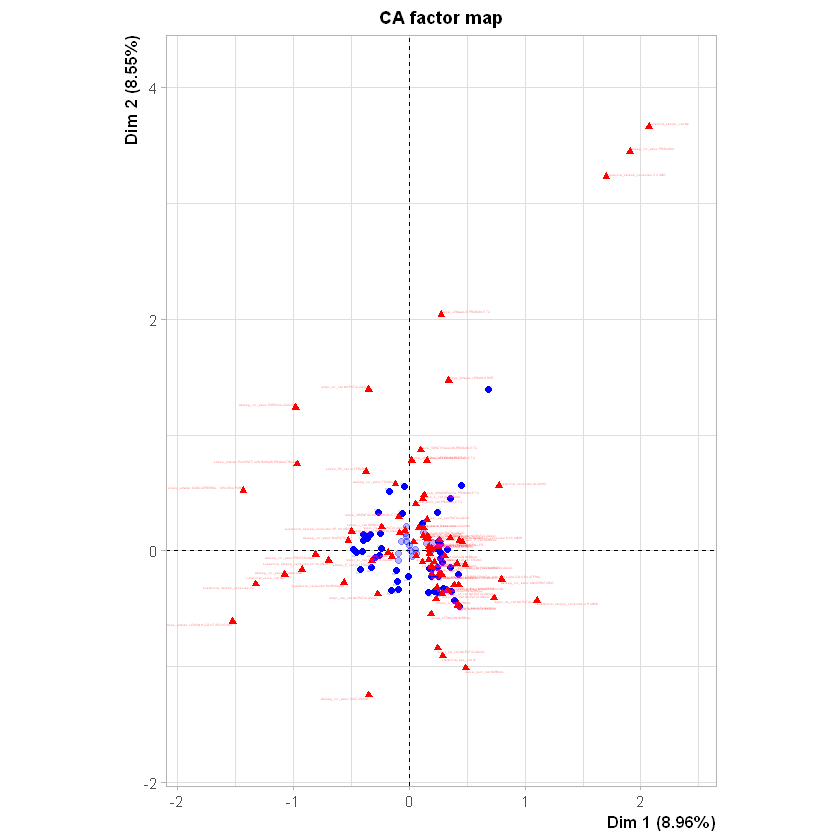

In [15]:
plot(ca2,
    cex=.15,
    selectRow="contrib 50")

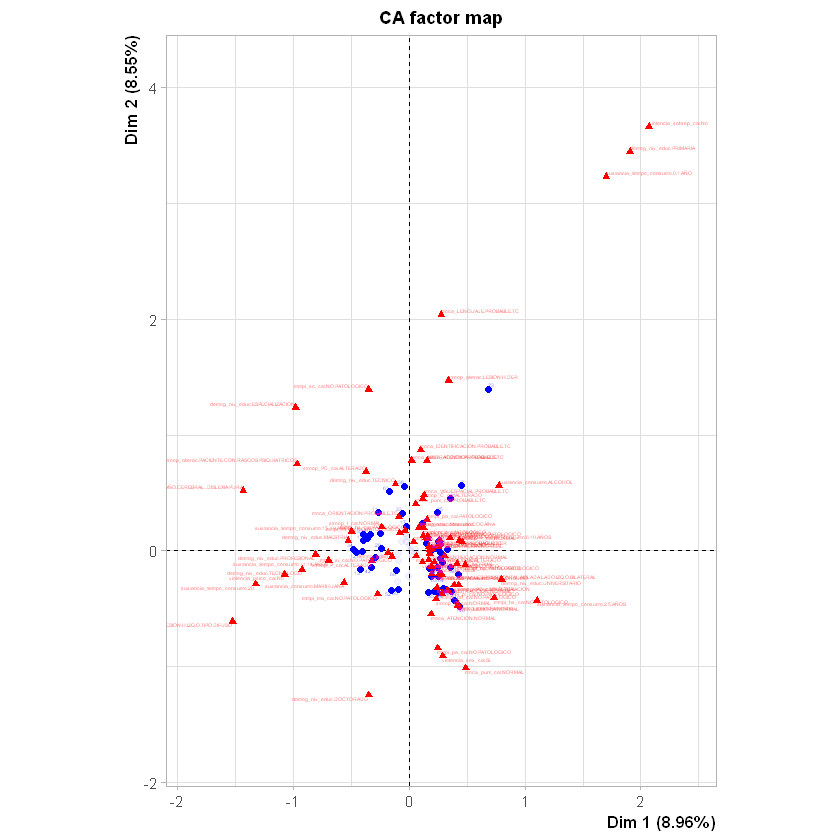

In [16]:
plot(ca2,
    shadowtext=TRUE,
    unselect=.95,
    cex=.25,
#     selectRow="contrib 25"
      selectRow="cos2 50"
    )


In [17]:
pdf("plano_correspondencias.pdf", width = 12, height = 12)

plot(ca2,
    shadowtext=TRUE,
    unselect=.95,
    cex=.15#,
#     selectRow="contrib 25"
    )
# Step 3: Run dev.off() to create the file!
dev.off()

png 
  2

In [18]:
viol_coord=ca2$col$coord[c("violencia_fis_cat.Si", 
                                "violencia_sex_cat.Si",
                                "violencia_psico_cat.Si",
                                "violencia_sobrep_cat.Si"),c(1,2)]
sust_cons=ca2$col$coord[c('sustancia_consumo.ALCOHOL',
                               'sustancia_consumo.MARIHUANA',
                               'sustancia_consumo.COCAINA',
                               'sustancia_consumo.POLICONSUMO'),c(1,2)]
moca_alt=ca2$col$coord[c('moca_punt_cat.PROBABLE.TC',
                     'moca_VISUESPACIAL.PROBABLE.TC',
                     'moca_IDENTIFICACION.PROBABLE.TC',
                     'moca_MEMORIA.PROBABLE.TC',
                     'moca_ATENCION.PROBABLE.TC',
                     'moca_LENGUAJE.PROBABLE.TC',
                     'moca_ABSTRACCION.PROBABLE.TC',
                     'moca_ORIENTACION.PROBABLE.TC'),c(1,2)]
stroop_alt=ca2$col$coord[c('stroop_alterac.DAÑO.CEREBRAL...DISLEXIA.PURA',
                                'stroop_alterac.LESION.H.IZQ.O.TIPO.DIFUSO',
                                'stroop_alterac.LESION.H.DER',
                                'stroop_alterac.LES.PRE.FRONTAL.AISLADA.LADO.IZQ.O.BILATERAL',
                                'stroop_alterac.PACIENTE.CON.RASGOS.PSIQUIATRICOS'),c(1,2)]

mmpi_patol=ca2$col$coord[c('mmpi_hs_cat.PATOLOGICO',
                                'mmpi_d_cat.PATOLOGICO',
                                'mmpi_hy_cat.PATOLOGICO',
                                'mmpi_pd_cat.PATOLOGICO',
                                'mmpi_mf_cat.PATOLOGICO',
                                'mmpi_pa_cat.PATOLOGICO',
                                'mmpi_pt_cat.PATOLOGICO',
                                'mmpi_sc_cat.PATOLOGICO',
                                'mmpi_ma_cat.PATOLOGICO',
                                'mmpi_si_cat.PATOLOGICO'),c(1,2)]

tiempo_consumo=ca2$col$coord[c('sustancia_tiempo_consumo.0.1.AÑO',
                                'sustancia_tiempo_consumo.2.5.AÑOS',
                                'sustancia_tiempo_consumo.6.10.AÑOS',
                                'sustancia_tiempo_consumo.11.14.AÑOS',
                                'sustancia_tiempo_consumo.15..19.AÑOS',
                                'sustancia_tiempo_consumo.20.'),c(1,2)]

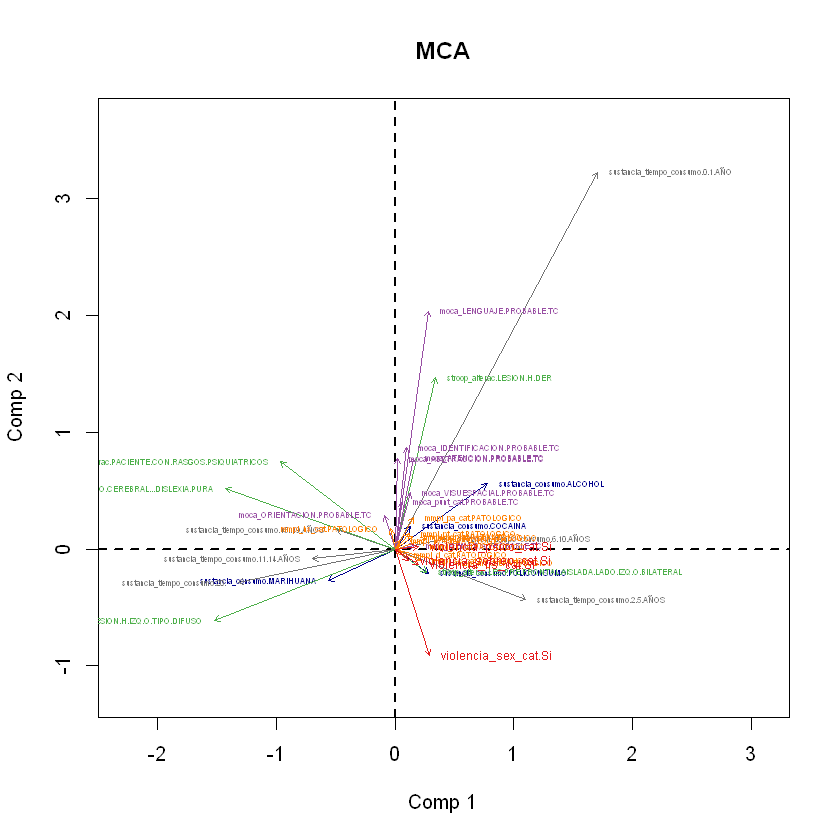

In [19]:
plot(0,0, 
     cex=.01, 
     xlim=c(min(ca2$col$coord[,"Dim 1"]*1.5),max(ca2$col$coord[,"Dim 1"]*1.5)), 
     ylim=c(min(ca2$col$coord[,"Dim 2"]),max(ca2$col$coord[,"Dim 2"])), 
     xlab="Comp 1", ylab="Comp 2", main="MCA")
# symbols(0,0,circles=1, inches=FALSE, add=TRUE)
abline(h=0, v=0, lty=2, lwd=2)

indic_variables_plot(sust_cons,color_plot="darkblue")
indic_variables_plot(tiempo_consumo,color_plot="gray45")
indic_variables_plot(stroop_alt,color_plot="#4daf4a")#green
indic_variables_plot(moca_alt,color_plot="#984ea3")# purple
indic_variables_plot(mmpi_patol,color_plot="#ff7f00")# orange

indic_variables_plot(viol_coord,color_plot="#e41a1c", txt_cex=.6)#red

In [20]:
pdf("plano_correspondencias_variables.pdf", width = 12, height = 12)
plot(0,0, 
     cex=.01, 
     xlim=c(min(ca2$col$coord[,"Dim 1"]*1.5),max(ca2$col$coord[,"Dim 1"]*1.5)), 
     ylim=c(min(ca2$col$coord[,"Dim 2"]),max(ca2$col$coord[,"Dim 2"])), 
     xlab="Comp 1", ylab="Comp 2", main="MCA")
# symbols(0,0,circles=1, inches=FALSE, add=TRUE)
abline(h=0, v=0, lty=2, lwd=2)

indic_variables_plot(sust_cons,color_plot="darkblue", txt_cex=.2)
indic_variables_plot(tiempo_consumo,color_plot="gray45", txt_cex=.2)
indic_variables_plot(stroop_alt,color_plot="#4daf4a", txt_cex=.2)#green
indic_variables_plot(moca_alt,color_plot="#984ea3", txt_cex=.2)# purple
indic_variables_plot(mmpi_patol,color_plot="#ff7f00", txt_cex=.2)# orange

indic_variables_plot(viol_coord,color_plot="#e41a1c", txt_cex=.25)#red

dev.off()

png 
  2

## Componentes principales
* [PCA FactoMineR](http://factominer.free.fr/factomethods/principal-components-analysis.html)
* [Intro PCA](http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/118-principal-component-analysis-in-r-prcomp-vs-princomp/)
* [PCA practical gide](http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/112-pca-principal-component-analysis-essentials/)
* [Plots PCA](https://cran.r-project.org/web/packages/ggfortify/vignettes/plot_pca.html)

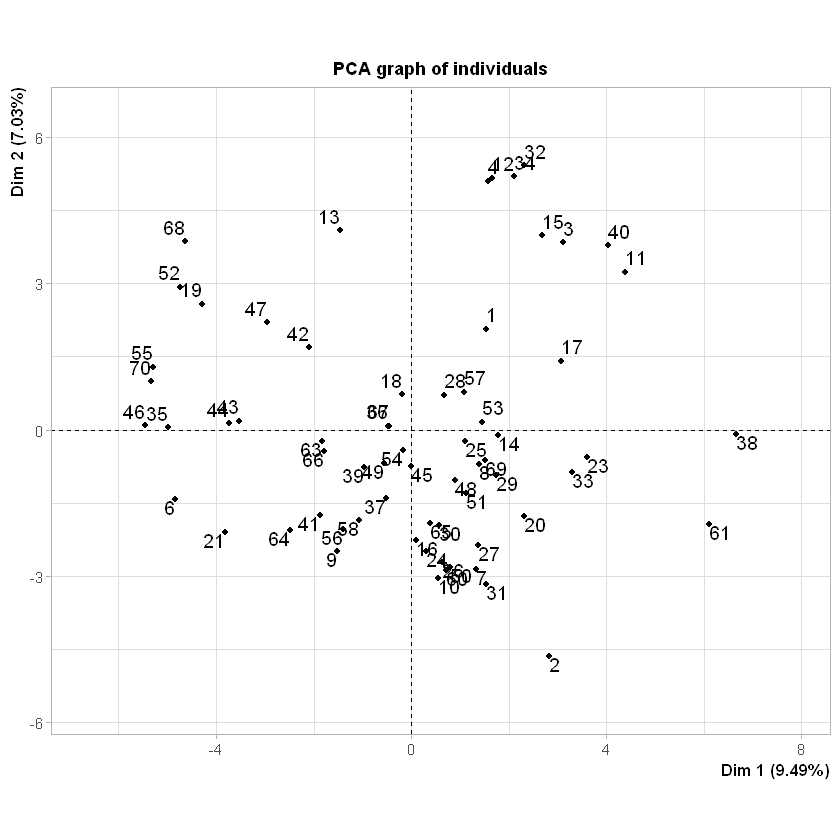

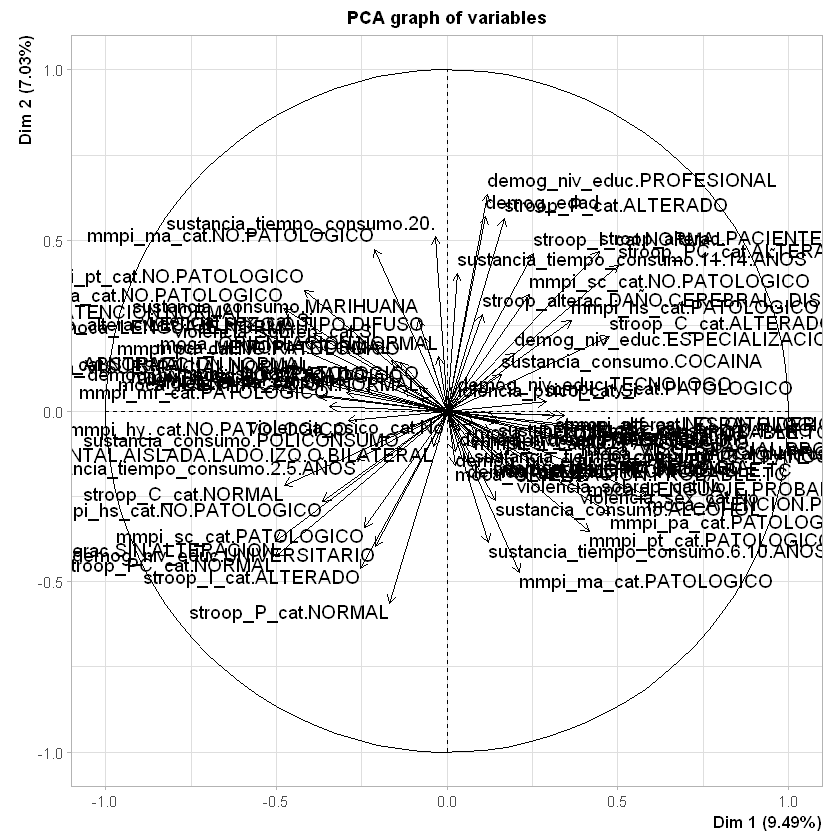

In [21]:
pca_vars= PCA(trsf, scale.unit=TRUE, ncp=5, graph=T)

In [22]:
print(pca_vars)
# rownames(pca_vars$var$coord)

**Results for the Principal Component Analysis (PCA)**
The analysis was performed on 66 individuals, described by 80 variables
*The results are available in the following objects:

   name               description                          
1  "$eig"             "eigenvalues"                        
2  "$var"             "results for the variables"          
3  "$var$coord"       "coord. for the variables"           
4  "$var$cor"         "correlations variables - dimensions"
5  "$var$cos2"        "cos2 for the variables"             
6  "$var$contrib"     "contributions of the variables"     
7  "$ind"             "results for the individuals"        
8  "$ind$coord"       "coord. for the individuals"         
9  "$ind$cos2"        "cos2 for the individuals"           
10 "$ind$contrib"     "contributions of the individuals"   
11 "$call"            "summary statistics"                 
12 "$call$centre"     "mean of the variables"              
13 "$call$ecart.type" "standard error o

In [23]:
viol_coord=pca_vars$var$coord[c("violencia_fis_cat.Si", 
                                "violencia_sex_cat.Si",
                                "violencia_psico_cat.Si",
                                "violencia_sobrep_cat.Si"),c(1,2)]
sust_cons=pca_vars$var$coord[c('sustancia_consumo.ALCOHOL',
                               'sustancia_consumo.MARIHUANA',
                               'sustancia_consumo.COCAINA',
                               'sustancia_consumo.POLICONSUMO'),c(1,2)]
moca_alt=pca_vars$var$coord[c('moca_punt_cat.PROBABLE.TC',
                     'moca_VISUESPACIAL.PROBABLE.TC',
                     'moca_IDENTIFICACION.PROBABLE.TC',
                     'moca_MEMORIA.PROBABLE.TC',
                     'moca_ATENCION.PROBABLE.TC',
                     'moca_LENGUAJE.PROBABLE.TC',
                     'moca_ABSTRACCION.PROBABLE.TC',
                     'moca_ORIENTACION.PROBABLE.TC'),c(1,2)]
stroop_alt=pca_vars$var$coord[c('stroop_alterac.DAÑO.CEREBRAL...DISLEXIA.PURA',
                                'stroop_alterac.LESION.H.IZQ.O.TIPO.DIFUSO',
                                'stroop_alterac.LESION.H.DER',
                                'stroop_alterac.LES.PRE.FRONTAL.AISLADA.LADO.IZQ.O.BILATERAL',
                                'stroop_alterac.PACIENTE.CON.RASGOS.PSIQUIATRICOS'),c(1,2)]

mmpi_patol=pca_vars$var$coord[c('mmpi_hs_cat.PATOLOGICO',
                                'mmpi_d_cat.PATOLOGICO',
                                'mmpi_hy_cat.PATOLOGICO',
                                'mmpi_pd_cat.PATOLOGICO',
                                'mmpi_mf_cat.PATOLOGICO',
                                'mmpi_pa_cat.PATOLOGICO',
                                'mmpi_pt_cat.PATOLOGICO',
                                'mmpi_sc_cat.PATOLOGICO',
                                'mmpi_ma_cat.PATOLOGICO',
                                'mmpi_si_cat.PATOLOGICO'),c(1,2)]

tiempo_consumo=pca_vars$var$coord[c('sustancia_tiempo_consumo.0.1.AÑO',
                                'sustancia_tiempo_consumo.2.5.AÑOS',
                                'sustancia_tiempo_consumo.6.10.AÑOS',
                                'sustancia_tiempo_consumo.11.14.AÑOS',
                                'sustancia_tiempo_consumo.15..19.AÑOS',
                                'sustancia_tiempo_consumo.20.'),c(1,2)]

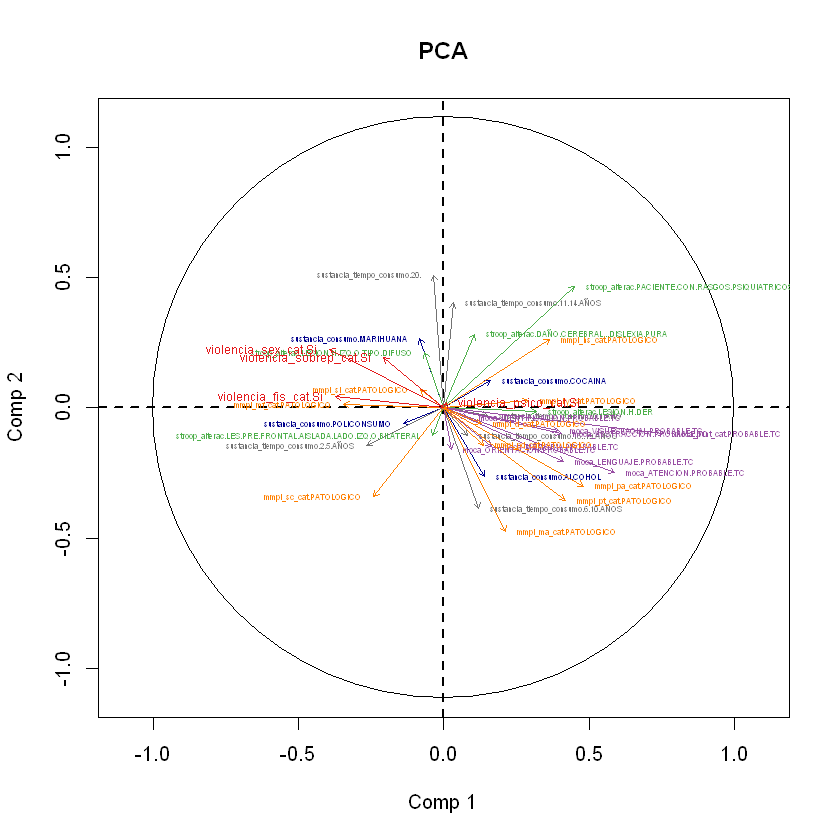

In [24]:
plot(0,0, cex=.01, xlim=c(-1.1,1.1), ylim=c(-1.1,1.1), xlab="Comp 1", ylab="Comp 2", main="PCA")
symbols(0,0,circles=1, inches=FALSE, add=TRUE)
abline(h=0, v=0, lty=2, lwd=2)

indic_variables_plot(sust_cons,color_plot="darkblue")
indic_variables_plot(tiempo_consumo,color_plot="gray45")
indic_variables_plot(stroop_alt,color_plot="#4daf4a")#green
indic_variables_plot(moca_alt,color_plot="#984ea3")# purple
indic_variables_plot(mmpi_patol,color_plot="#ff7f00")# orange

indic_variables_plot(viol_coord,color_plot="#e41a1c", txt_cex=.6)#red

In [25]:
pdf("PCA Variables.pdf", width = 12, height = 12)

plot(0,0, cex=.01, xlim=c(-1.1,1.1), ylim=c(-1.1,1.1))
symbols(0,0,circles=1, inches=FALSE, add=TRUE)
abline(h=0, v=0, lty=2, lwd=2)

indic_variables_plot(sust_cons,color_plot="darkblue", txt_cex=.2)
indic_variables_plot(tiempo_consumo,color_plot="gray45", txt_cex=.2)
indic_variables_plot(stroop_alt,color_plot="#4daf4a", txt_cex=.2)#green
indic_variables_plot(moca_alt,color_plot="#984ea3", txt_cex=.2)# purple
indic_variables_plot(mmpi_patol,color_plot="#ff7f00", txt_cex=.2)# orange

indic_variables_plot(viol_coord,color_plot="#e41a1c", txt_cex=.25)#red


dev.off()

png 
  2